In [72]:
import numpy as np
import control.matlab as m
import matplotlib.pyplot as plt

from pathlib import Path
from scipy.interpolate import interp1d

# Header

In [73]:
'''
PARÂMETROS GERAIS
'''
PATH_IMAGES = Path('imagesAvl3')

param       = {'color':'lightgrey', 'linestyle':'--', 'linewidth':2, 'edgecolor':'k', 'alpha':1, 'hatch':'/'}
tam         = (20,5)

'''
FUNÇÕES ÚTEIS
'''
def epsf(a:float)->float:
    return (10**(-0.1*a) -1)

def savefig(fig:plt, name:str, format:str = 'png', dpi:int = 720, path:Path = PATH_IMAGES) -> None:
    path.mkdir(exist_ok=True)
    if not path.joinpath(f'{name}.{format}').exists():
        fig.savefig(path.joinpath(f'{name}.{format}'), format = format, dpi = dpi)

'''
FILTRO DE BUTTERWORTH
'''
def thetam (n:int)->np.ndarray:
    aux     = 0 if n%2 == 0 else 1
    mfinal  = (n-aux)/2 - 1
    m       = np.arange(0, mfinal+1)
    
    return np.pi*(2*m + n + 1)/(2*n)

def FT(n:int, R:float)-> any:
        print(10*'-'+'BUTTERWORTH FILTER'+10*'-')
    
        sigma_m = R*np.cos(thetam(n))
        omega_m = R*np.sin(thetam(n))
        exp     = 0 if n%2 == 0 else 1

        s  = m.tf('s')
        
        B1 = -2*sigma_m
        B2 = sigma_m**2 + omega_m**2

        aux = np.array([1])
        for i in range(len(sigma_m)):
            a   = np.array([1, B1[i], B2[i]])
            aux = np.polymul(aux,a)
        
        h1 = lambda S: sum([S**j *aux[j] for j in range(len(aux))])
        h2 = lambda S: (S+R)**(exp)
        H  = lambda S: R**(exp)*np.prod(B2)/(h1(S)*h2(S))

        # Prints
        print('\n--> Alocação dos Polos:')
        print(f'theta_m\t= {np.round(thetam(n),3)} [rad]')
        print(f'theta_m\t= {np.round(np.rad2deg(thetam(n)),3)} [deg]')
        print(f'sigma_m\t= {np.round(sigma_m,3)} [u.c.]')
        print(f'omega_m\t= {np.round(omega_m,3)} [u.c.]') 
        if not n%2 == 0:
            print(f'sigma_r\t= {round(-R,3)} [u.c]')
        
        print(f'\n--> Função de transferência normalizada:')
        print(f'B1m\t= {np.round(B1,3)}')
        print(f'B2m\t= {np.round(B2,3)}')
        print(f'Hb\t= {H(s)}')
        return H
        
def cascata(H:m.TransferFunction, dt:float)-> list:
     
    pole = m.pole(H)
    zero = m.zero(H)
    n    = len(pole)
    
    
    n2th = int(n/2)
    n1th = n%2


    print('\n'+10*'-'+'cascata'+'-'*10)
    print('\n'+f'--> n° 2th order: {n2th}\n')
    Hanal = []
    for i in range(n2th):
        den = np.polymul([1, -pole[i]], [1, -pole[i+1]]).real
        num = np.polymul([1, -zero[i]], [1, -zero[i+1]]).real
        aux = m.tf(num, den, dt)
        print(f'H{i} = {aux}')
        print(f'an = {np.round(num,4)}')
        print(f'bj = {np.round(den,4)}')

        Hanal.append(aux)
        
    print('\n'+f'--> n° 1th order: {n1th}')
    for j in range(n1th):
        den = [1, -pole[j+i].real]
        num = [1, -zero[j+i].real]
        
        aux1 = m.tf(num, den, dt)
        print(f'H{i+j} = {aux1}')
        print(f'alpha = {np.round(num[1],4)}')
        print(f'beta =  {np.round(den[1],4)}')

        Hanal.append(aux1)

    return Hanal


# Filtro de Butterworth

## Projeto do filtro passa-baixas discreto

#### --> Dados de entrada

In [74]:
# Dados gerais
matricula   = np.array([1,8,2,0,2,7,7,2])
factor      = len(matricula)/2

# Filtro passa-baixas
apass       = -3                     #[dB]
n           = 5
fpass       = sum(matricula)/factor  #[Hz]
omega0      = 2*np.pi*fpass

print(10*'-'+'Passa-baixas'+'-'*10)
print(f'apass\t= {apass}\t\tdB')
print(f'fpass\t= {fpass}\t\tHz')
print(f'omega0\t= {round(omega0,3)}\trad/s')
print(f'nº order = {n}')

----------Passa-baixas----------
apass	= -3		dB
fpass	= 7.25		Hz
omega0	= 45.553	rad/s
nº order = 5


#### --> Passa-baixas normalizado

epsilon	= 0.998
R	= 1.0 [u.c] (p/n = 5)

----------BUTTERWORTH FILTER----------

--> Alocação dos Polos:
theta_m	= [1.885 2.513] [rad]
theta_m	= [108. 144.] [deg]
sigma_m	= [-0.309 -0.809] [u.c.]
omega_m	= [0.952 0.588] [u.c.]
sigma_r	= -1.0 [u.c]

--> Função de transferência normalizada:
B1m	= [0.618 1.619]
B2m	= [1.001 1.001]
Hb	= 
                           1.002
-----------------------------------------------------------
1.002 s^5 + 3.242 s^4 + 5.243 s^3 + 5.241 s^2 + 3.238 s + 1



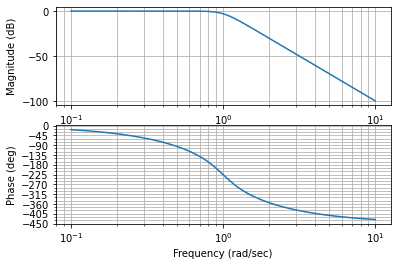

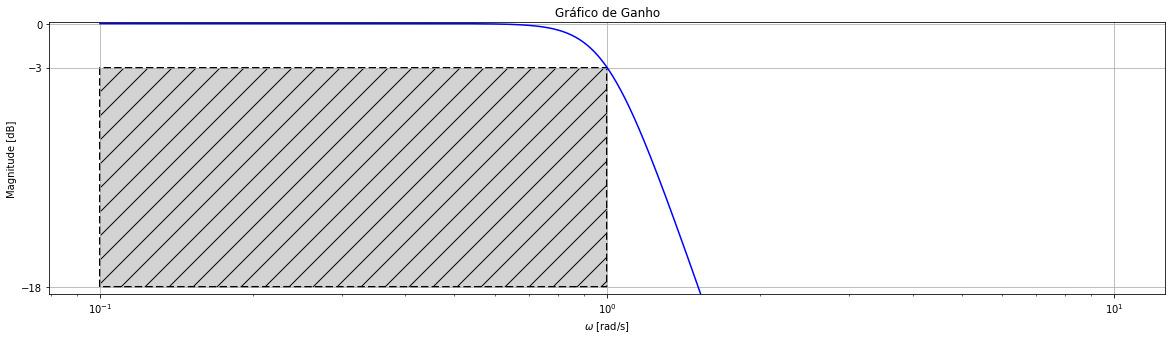

In [75]:
# fator de ajuste
eps = np.sqrt(epsf(apass))

print(f'epsilon\t= {round(eps,3)}')

# alocação dos polos
R = eps**(-1/(n))

print(f'R\t= {round(R,3)} [u.c] (p/n = {n})\n')

# função de transferência
s   = m.tf('s')
H   = FT(n,R)
Hr = H(s)

# Diagrama de Bode
mag, phase, omega = m.bode(Hr, plot = True)
magdB = 20*np.log10(mag)
savefig(plt.gcf(), 'bodePBnorm')
plt.show()

with plt.rc_context({'figure.figsize':tam}):

    plt.semilogx(omega, magdB, 'b')
    plt.fill_between([omega[0], 1], [apass, apass],[-18,-18],**param)
    
    plt.yticks([0,-3,-18])
    plt.ylim([-18.5,0.1])
    plt.title('Gráfico de Ganho')
    plt.xlabel(r'$\omega$ [rad/s]')
    plt.ylabel('Magnitude [dB]')

    plt.grid(axis = 'both')

    savefig(plt.gcf(), 'ganhoPBnorm')
    plt.show()




#### --> Conversão para o filtro passa-altas

0 states have been removed from the model
HrL	= 
                                1.962e+08
-------------------------------------------------------------------------
s^5 + 147.4 s^4 + 1.086e+04 s^3 + 4.945e+05 s^2 + 1.392e+07 s + 1.959e+08



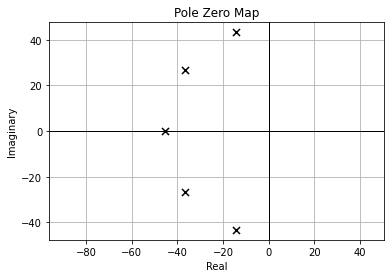

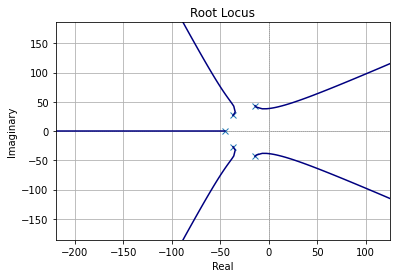

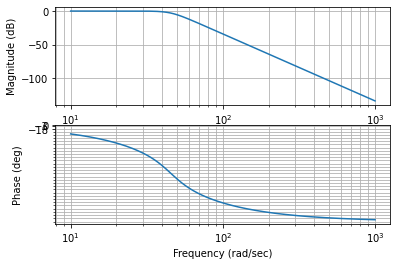

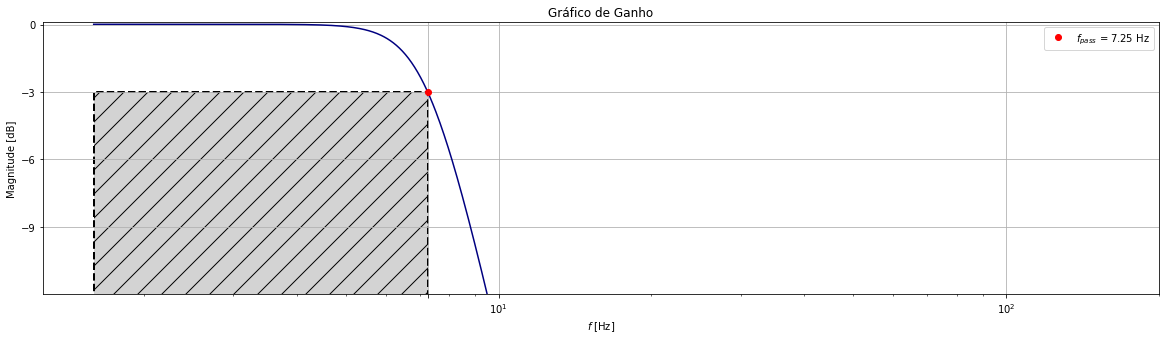

In [76]:
# Função de transferência
s = m.tf('s')
HrL = m.minreal(H(s/omega0))
print(f'HrL\t= {HrL}')

# Pole zero map
m.pzmap(HrL, 'b')
plt.grid()

savefig(plt.gcf(), 'pzmapPA')
plt.show()

# Root-Locus
m.rlocus(HrL, grid = False, plotstr = 'navy')
plt.grid()

savefig(plt.gcf(), 'rlocusPA')
plt.show()

# Diagrama de Bode
mag, phase, omega = m.bode(HrL, plot = True, dB = True)
magdB = 20*np.log10(mag)
plt.yticks([0,-3,-18])
savefig(plt.gcf(), 'bodePA')
plt.show()

magdB   = 20*np.log10(mag)
freqPB  = omega/(2*np.pi)
magdBf  = interp1d(freqPB,magdB)

with plt.rc_context({'figure.figsize':tam}):
    
    plt.semilogx(freqPB, magdB, 'navy')
    plt.fill_between([freqPB[0], fpass]   , [-3, -3] , [-18, -18]  ,  **param)

    plt.plot(fpass, magdBf(fpass),'ro', label = r'$f_{pass}$ = '+f'{round(fpass,3)} Hz')    
    
    plt.yticks(np.arange(0,-12,-3))
    plt.xticks([fpass, 10, 100])

    plt.ylim([-12,0.1])
    plt.title('Gráfico de Ganho')
    plt.xlabel(r'$f$ [Hz]')
    plt.ylabel('Magnitude [dB]')

    plt.grid(axis = 'both')
    plt.legend()

    savefig(plt.gcf(), 'ganhoPA')
    plt.show()

#### --> Discretização do passa-baixas

In [77]:
# Discretização pela transformação bilinear
Ts = fpass/10

HzL = m.c2d(HrL, Ts, method = 'tustin')
print(f'HzL = {HzL}')

# Estrutura canônica e não-canônica
aEC = np.round(HzL.num[0][0],4)
bEC = np.round(HzL.den[0][0],4)

print(10*'-'+'Estrura de implementação discreta'+'-'*10)
print(f'an = {aEC}')
print(f'bj = {bEC}')

# Estrutura cascata
H = cascata(HzL, dt = Ts)

HzL = 
0.8236 z^5 + 4.118 z^4 + 8.236 z^3 + 8.236 z^2 + 4.118 z + 0.8236
-----------------------------------------------------------------
    z^5 + 4.609 z^4 + 8.51 z^3 + 7.869 z^2 + 3.644 z + 0.6758

dt = 0.725

----------Estrura de implementação discreta----------
an = [0.8236 4.1182 8.2364 8.2364 4.1182 0.8236]
bj = [1.     4.6085 8.5096 7.8689 3.6436 0.6758]

----------cascata----------

--> n° 2th order: 2

H0 = 
z^2 + 2.002 z + 1.002
----------------------
z^2 + 1.914 z + 0.9281

dt = 0.725

an = [1.     2.0024 1.0024]
bj = [1.     1.914  0.9281]
H1 = 
z^2 + 2.001 z + 1.001
----------------------
z^2 + 1.861 z + 0.8726

dt = 0.725

an = [1.     2.0008 1.0008]
bj = [1.     1.8613 0.8726]

--> n° 1th order: 1
H1 = 
z + 1.001
---------
z + 0.957

dt = 0.725

alpha = 1.0012
beta =  0.957
